# Adapted from

https://github.com/Project-MONAI/tutorials/blob/main/modules/transfer_mmar.ipynb

In [1]:
# !pip install monai
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, lmdb, tqdm]"

In [2]:
import os, sys, shutil, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *

import matplotlib.pyplot as plt

# MONAI
from monai.networks.nets import UNet
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import (
    Dataset,
    CacheDataset,
    LMDBDataset,
    DataLoader,
    decollate_batch,
)

from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups

from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    PadListDataCollate,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    Orientationd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotated,
    EnsureType,
    EnsureTyped,
    ToTensord,
)

%matplotlib inline


# Get labels

In [3]:
root = "/home/gologors/data/"

with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'rb') as f: 
    all_filenames = pickle.load(f)
    
# Split into training/valid and testing 
# adapted from https://github.com/Project-MONAI/tutorials/blob/main/modules/autoencoder_mednist.ipynb

test_frac = 0.2
valid_frac = 0.2

num_test  = int(len(all_filenames) * test_frac)
num_valid = int(len(all_filenames) * valid_frac)
num_train = len(all_filenames) - num_test - num_valid

train_datadict = [{"im": nii, "lbl":obj} for nii,obj in all_filenames[:num_train]]
valid_datadict = [{"im": nii, "lbl":obj} for nii,obj in all_filenames[num_train:num_train+num_valid]]
test_datadict = [{"im": nii, "lbl": obj} for nii,obj in all_filenames[-num_test:]]

print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for val: {len(valid_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 50
number of images for training: 30
number of images for val: 10
number of images for testing: 10


In [4]:
# Shapes
all_shapes = []
for im_fn, lbl_fn in all_filenames:
    lbl_pt = torch.load(lbl_fn)
    all_shapes.append(tuple(lbl_pt.shape))
    print(lbl_pt.shape)

torch.Size([512, 512, 16])
torch.Size([320, 320, 14])
torch.Size([512, 512, 18])
torch.Size([512, 512, 14])
torch.Size([432, 432, 24])
torch.Size([256, 256, 24])
torch.Size([512, 512, 17])
torch.Size([256, 256, 11])
torch.Size([512, 512, 16])
torch.Size([432, 432, 18])
torch.Size([512, 512, 18])
torch.Size([512, 512, 16])
torch.Size([512, 512, 16])
torch.Size([300, 384, 15])
torch.Size([512, 512, 16])
torch.Size([336, 336, 14])
torch.Size([512, 512, 17])
torch.Size([512, 512, 18])
torch.Size([512, 512, 16])
torch.Size([576, 640, 17])
torch.Size([256, 256, 11])
torch.Size([512, 512, 20])
torch.Size([512, 512, 18])
torch.Size([512, 512, 16])
torch.Size([512, 512, 25])
torch.Size([512, 512, 18])
torch.Size([448, 448, 14])
torch.Size([336, 336, 14])
torch.Size([512, 512, 16])
torch.Size([432, 432, 18])
torch.Size([384, 384, 13])
torch.Size([512, 512, 12])
torch.Size([432, 432, 22])
torch.Size([400, 400, 42])
torch.Size([288, 288, 20])
torch.Size([512, 512, 15])
torch.Size([256, 256, 17])
t

In [5]:
print("Shapes of tensors")

print("Dim 0")
print(min(all_shapes, key=lambda s: s[0]))
print(max(all_shapes, key=lambda s: s[0]))

print("Dim 1")
print(min(all_shapes, key=lambda s: s[1]))
print(max(all_shapes, key=lambda s: s[1]))

print("Dim 2")
print(min(all_shapes, key=lambda s: s[2]))
print(max(all_shapes, key=lambda s: s[2]))

Shapes of tensors
Dim 0
(256, 256, 24)
(576, 640, 17)
Dim 1
(256, 256, 24)
(576, 640, 17)
Dim 2
(336, 336, 7)
(400, 400, 42)


# Transforms

In [6]:
largest_sz         = (576, 640, 42)
largest_sz         = (576, 640, 96)
center_crop_sz     = (288, 288, 96)

In [7]:
def load_pt(x):
    d = {}
    # do stuff to image
    for key, val in x.items():
        d[key] = torch.load(val)
    return d

In [8]:
# Transforms
from helpers.transforms_simplified import UndoDict

train_transforms = Compose(
    [
        load_pt,
        AddChanneld(keys=["im", "lbl"]),
        SpatialPadd(keys=["im", "lbl"], spatial_size=largest_sz, method="symmetric", mode="constant"),
        CenterSpatialCropd(keys=["im", "lbl"], roi_size=center_crop_sz),
        UndoDict(keys=["im", "lbl"])
    ]
)

valid_transforms = train_transforms

In [9]:
check_ds = Dataset(data= [{"im": nii, "lbl": obj} for nii,obj in all_filenames], transform=valid_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


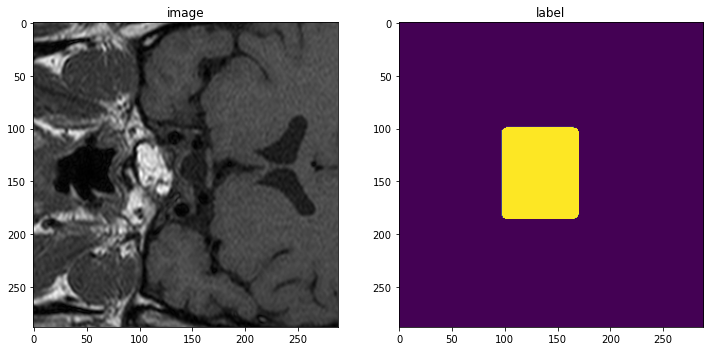

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


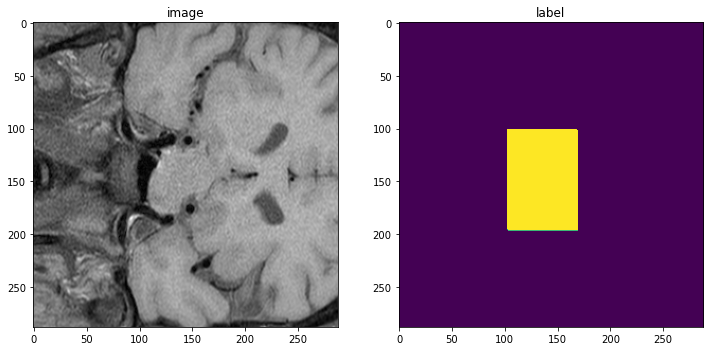

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


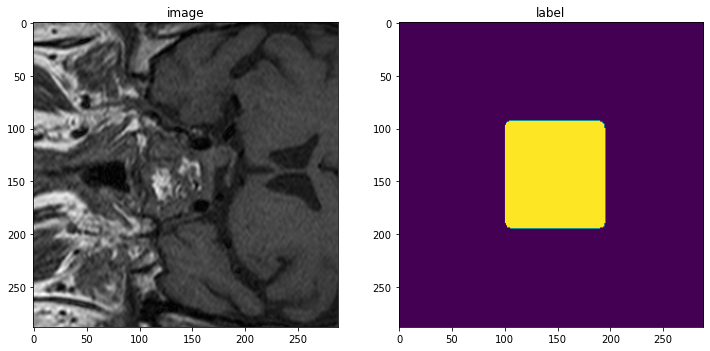

In [10]:
count_ims = 0
for check_data in check_loader:
    image, label = check_data[0][0][0], check_data[1][0][0] #(check_data["im"][0][0], check_data["lbl"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 21]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, center_crop_sz[2]//2], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, center_crop_sz[2]//2])
    plt.show()
    
    count_ims += 1
    
    if count_ims == 3:
        break

In [14]:
# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback, CSVLogger, ProgressCallback

# clear cache
torch.cuda.empty_cache()

from helpers.general import print_hardware_stats
print_hardware_stats()

#GPU = 1, #CPU = 16
GPU NVIDIA TITAN V       RAM Free: 12062MB | Used: 4MB | Util   0% | Total 12066MB


In [15]:
bs = 2

train_dl = TfmdDL(train_datadict, after_item=train_transforms, after_batch=[], bs=bs)
val_dl   = TfmdDL(valid_datadict,   after_item=valid_transforms,   after_batch=[], bs=bs)


dls = DataLoaders(train_dl, val_dl)
dls = dls.cuda()

In [16]:
PRETRAINED = True


unet_path = f"/home/gologors/pitmri/PituitaryGenerator/unet/model.pth"
checkpoint = torch.load(unet_path)

In [17]:
print(checkpoint.keys())
print(checkpoint["opt"].keys())

dict_keys(['model', 'opt'])
dict_keys(['state', 'hypers'])


In [18]:
# UNET model
model = UNet(
                    dimensions=3,
                    in_channels=1,
                    out_channels=2,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                    num_res_units=2,
                    dropout=0.0,
                )

In [19]:
# copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
    model, checkpoint["model"])

print("num. var. using the pretrained", len(updated_keys), ", random init", len(unchanged_keys), "variables.")
model.load_state_dict(pretrained_dict)

print([x[0] for x in model.named_parameters()])
print(unchanged_keys)

# # copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
# pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
#     model, checkpoint["model"], exclude_vars="model.0.conv.unit0")
# print("num. var. using the pretrained", len(updated_keys), ", random init", len(unchanged_keys), "variables.")
# model.load_state_dict(pretrained_dict)

# print([x[0] for x in model.named_parameters()])
# print(unchanged_keys)

# # stop gradients for the pretrained weights
# for x in model.named_parameters():
#     if x[0] in updated_keys:
#         x[1].requires_grad = False
# params = generate_param_groups(
#     network=model,
#     layer_matches=[lambda x: x[0] in updated_keys],
#     match_types=["filter"],
#     lr_values=[1e-4],
#     include_others=False
# )

'dst' model updated: 63 of 63 variables.
num. var. using the pretrained 63 , random init 0 variables.
['model.0.conv.unit0.conv.weight', 'model.0.conv.unit0.conv.bias', 'model.0.conv.unit0.adn.A.weight', 'model.0.conv.unit1.conv.weight', 'model.0.conv.unit1.conv.bias', 'model.0.conv.unit1.adn.A.weight', 'model.0.residual.weight', 'model.0.residual.bias', 'model.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.0.conv.unit0.adn.A.weight', 'model.1.submodule.0.conv.unit1.conv.weight', 'model.1.submodule.0.conv.unit1.conv.bias', 'model.1.submodule.0.conv.unit1.adn.A.weight', 'model.1.submodule.0.residual.weight', 'model.1.submodule.0.residual.bias', 'model.1.submodule.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.1.submodule.0.conv.unit0.adn.A.weight', 'model.1.submodule.1.submodule.0.conv.unit1.conv.weight', 'model.1.submodule.1.submodule.0.conv.unit1.conv.bias', 'model

In [20]:
from fastai.vision.all import *

In [22]:
# # check
# print("Check")
# b = dls.one_batch()
# xb,yb = b #b["image"], b["label"]
# print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
# predb = learn.model(xb)
# print(f"Pred batch: {predb.shape}")
# loss = loss_fn(predb, yb)
# print(f"Loss: {loss}")

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = ", device)

model = model.to(device)

Device =  cuda:0


In [25]:
model_src = f"/home/gologors/data/saved_models/transfer_learning_unet/fastai/try2/"
fig_src   = f"{model_src}/figs"
Path(fig_src).mkdir(parents=True, exist_ok=True)

In [26]:
from helpers.losses import dice_loss, dice_score

loss_fn = dice_loss

In [27]:
# cbs
cbs = [
    Recorder(train_metrics=True), # False
    SaveModelCallback(monitor='valid_dice_score', with_opt=True), 
    CSVLogger(fname=f"{fig_src}/history.csv")
]

# learner
learn = Learner(dls   = dls, \
                model     = model, \
                loss_func = loss_fn, \
                metrics   = dice_score, \
                model_dir = model_src, \
                cbs       = [])

# remove post-recorder, add new cbs, to GPU
learn.remove_cbs(learn.cbs[1:])
learn.add_cb(ProgressCallback())
learn.add_cbs(cbs)
learn.model = learn.model.cuda()

In [28]:
# check
print("Check")
b = dls.one_batch()
xb,yb = b #b["image"], b["label"]
print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
predb = learn.model(xb)
print(f"Pred batch: {predb.shape}")
loss = loss_fn(predb, yb)
print(f"Loss: {loss}")

Check
Batch: 2. xb: torch.Size([2, 1, 288, 288, 96]), yb: torch.Size([2, 1, 288, 288, 96])
Pred batch: torch.Size([2, 2, 288, 288, 96])
Loss: 0.8888070583343506


In [ ]:
learn.fit_one_cycle(60, 3e-3, wd=1e-4)

epoch,train_loss,train_dice_score,valid_loss,valid_dice_score,time
0,0.876397,0.122366,0.868614,0.131992,00:20
1,0.870476,0.135111,0.857754,0.145051,00:12
2,0.864152,0.147039,0.849214,0.152494,00:12
3,0.857391,0.156168,0.842414,0.160266,00:12
4,0.849733,0.168947,0.838794,0.165040,00:12
5,0.839961,0.187857,0.844343,0.157479,00:12
6,0.828283,0.205789,0.835605,0.167248,00:12
7,0.816017,0.221233,0.820375,0.183233,00:12
8,0.803250,0.236999,0.798145,0.207345,00:12
9,0.791946,0.244389,0.782270,0.223661,00:12


Better model found at epoch 0 with valid_dice_score value: 0.1319921612739563.
Better model found at epoch 1 with valid_dice_score value: 0.14505068957805634.
Better model found at epoch 2 with valid_dice_score value: 0.15249434113502502.
Better model found at epoch 3 with valid_dice_score value: 0.16026625037193298.
Better model found at epoch 4 with valid_dice_score value: 0.16503962874412537.
Better model found at epoch 6 with valid_dice_score value: 0.1672479808330536.
Better model found at epoch 7 with valid_dice_score value: 0.18323345482349396.
Better model found at epoch 8 with valid_dice_score value: 0.20734469592571259.
Better model found at epoch 9 with valid_dice_score value: 0.22366078197956085.
Better model found at epoch 10 with valid_dice_score value: 0.22907677292823792.
Better model found at epoch 11 with valid_dice_score value: 0.23015756905078888.
Better model found at epoch 12 with valid_dice_score value: 0.2571027874946594.
Better model found at epoch 13 with vali

In [72]:
learn.unfreeze()

SuggestedLRs(valley=0.3019951581954956)

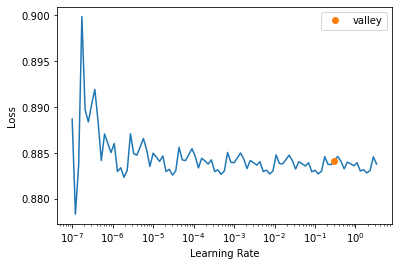

In [73]:
learn.lr_find()

In [74]:
learn.fit_one_cycle(50, lr_max=slice(1e-4,1e-2))

epoch,train_loss,train_dice_score,valid_loss,valid_dice_score,time
0,0.882963,0.114589,0.884153,0.113444,00:11
1,0.882956,0.114597,0.884135,0.113455,00:11
2,0.882946,0.114616,0.884110,0.113483,00:11
3,0.882934,0.114635,0.884070,0.113519,00:11
4,0.882916,0.114669,0.884011,0.113589,00:11
5,0.882897,0.114692,0.883985,0.113605,00:11
6,0.882877,0.114717,0.883913,0.113677,00:11
7,0.882848,0.114769,0.883791,0.113815,00:11
8,0.882809,0.114832,0.883685,0.113928,00:11
9,0.882778,0.114846,0.883734,0.113867,00:11


Better model found at epoch 0 with valid_dice_score value: 0.1134435161948204.
Better model found at epoch 1 with valid_dice_score value: 0.11345529556274414.
Better model found at epoch 2 with valid_dice_score value: 0.11348267644643784.
Better model found at epoch 3 with valid_dice_score value: 0.11351887881755829.
Better model found at epoch 4 with valid_dice_score value: 0.1135890930891037.
Better model found at epoch 5 with valid_dice_score value: 0.11360538005828857.
Better model found at epoch 6 with valid_dice_score value: 0.11367714405059814.
Better model found at epoch 7 with valid_dice_score value: 0.11381468921899796.
Better model found at epoch 8 with valid_dice_score value: 0.1139279156923294.
Better model found at epoch 10 with valid_dice_score value: 0.11399451643228531.
Better model found at epoch 12 with valid_dice_score value: 0.11401806771755219.
Better model found at epoch 20 with valid_dice_score value: 0.11423484981060028.


KeyboardInterrupt: 

# Plot Loss and Metric

In [59]:
@delegates(subplots)
def save_plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    # 'train_loss', 'train_dice_score', 'valid_loss', 'valid_dice_score'
    names = self.metric_names[1:-1]
    print("Metric names: ", names)
    
    names_train = [n for n in names if n.startswith("train")]
    n = len(names_train)
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs):
        name = names_train[i]
        n = name[name.index("_")+1:]
        valid_name = f"valid_{n}"
        valid_idx = names.index(valid_name)
        print(i, valid_idx, name, valid_name)
        ax.plot(metrics[:, i], color='#1f77b4',  label='train')
        ax.plot(metrics[:, valid_idx], color = '#ff7f0e', label='valid')
        ax.set_title(n)
        ax.legend(loc='best')
    #plt.show()
    plt.savefig(f'{fig_src}/metrics.png', bbox_inches='tight')
    plt.close()

In [60]:
save_plot_metrics(learn.recorder)

Metric names:  ['train_loss', 'train_dice_score', 'valid_loss', 'valid_dice_score']
0 2 train_loss valid_loss
1 3 train_dice_score valid_dice_score


In [ ]:
model.load_state_dict(torch.load(
    os.path.join(save_model_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break